In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()

In [0]:
!chmod 600 kaggle.json

In [0]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle competitions download -c 20-newsgroups-ciphertext-challenge

  0% 0.00/556k [00:00<?, ?B/s]
100% 556k/556k [00:00<00:00, 71.2MB/s]
 31% 5.00M/16.2M [00:00<00:00, 40.9MB/s]
100% 16.2M/16.2M [00:00<00:00, 79.2MB/s]
  0% 0.00/6.98M [00:00<?, ?B/s]
100% 6.98M/6.98M [00:00<00:00, 62.9MB/s]


In [6]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


# Objective
Multiclass classification on ciphered texts.

# Data
Source: https://www.kaggle.com/c/20-newsgroups-ciphertext-challenge/ </br>
and http://qwone.com/~jason/20Newsgroups/ </br>
The competition dataset is a well-known dataset often used as a sample set for multiclass classification and NLP. The original dataset contains $\approx$ 20 000 documents, partitioned (nearly) evenly across 20 different newsgroups. The newsgroups (partitioned according to subject matter) are: </br>

*   comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x
*   rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey
*   sci.crypt, sci.electronics, sci.med, sci.space
*   talk.politics.misc, talk.politics.guns, talk.politics.mideast
*   talk.religion.misc, alt.atheism, soc.religion.christian
*   misc.forsale

For the competition the dataset was encrypted with up to 4 classis ciphers. Every document in the dataset was broken into sequential 300-character chunks, and all chunks for the document were then encrypted based on its difficulty level. A difficulty of 1 means that only cipher #1 was used. A difficulty of 2 means cipher #1 was applied, followed by cipher #2, and so on. The difficulty level denotes exactly which ciphers were applied, and in what order.

In [0]:
import pandas as pd
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [8]:
df = pd.read_csv("train.csv")
print("Number of rows in the dataset: ", df.shape[0])

Number of rows in the dataset:  39052


In [9]:
df.head()

,Id,difficulty,ciphertext,target
0,ID_88b9bbd73,4,"ob|I K?zzhX*L{83B3Z,FuL*Pusm$83L\t@r$$*38,8s...",10
1,ID_f489bd59f,1,c1|FaAO120O'8ovfoy1W#atvGs1[1s1[1/1]O-a8o1-...,13
2,ID_f90fee9c7,2,1*e4N8$f$0ccOuihkHek$k*V*hoeV$Hj8VhH8...,19
3,ID_8303ced65,1,O8v^10O#to1'#^'^tv1^]s111t01Otaq>-ata_1...,17
4,ID_72abc2cb7,2,eV}H}khfe4b8'S.Vc}{A .#VikV.fV?{$f7$Hjb8...,0


#Deciphering simple ciphers

Now here is the trick: looking up kernels for this dataset on Kaggle, I found out that a user named Flal already cracked cipher #1 and cipher #2 (which were simple [substitution ciphers](https://en.wikipedia.org/wiki/Substitution_cipher), decipherable by manually mapping symbol frequences). Cipher #3 (and therefore cipher #4) wasn't decipherable this way.</br>
Here is Flal's notebook with cipher #1 and cipher #2 full solutions: </br>
https://www.kaggle.com/leflal/cipher-1-cipher-2-full-solutions </br>
I decided to use this solution to ease the problem.

In [10]:
!wget https://www.dropbox.com/s/mtmfzdkgt0oavrm/cipher1_map.csv?dl=0 -O cipher1_map.csv

--2019-06-20 19:05:19--  https://www.dropbox.com/s/mtmfzdkgt0oavrm/cipher1_map.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mtmfzdkgt0oavrm/cipher1_map.csv [following]
--2019-06-20 19:05:19--  https://www.dropbox.com/s/raw/mtmfzdkgt0oavrm/cipher1_map.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca0d4fa94188089dd498217b124.dl.dropboxusercontent.com/cd/0/inline/AjNeMdaOl9oElazslvs4OCk-mT8ekhrGrSMgiAFpbrAXHNjZc1D6AWbetHaw_wE5VyqQtLf7ALtojUukn8yYD4SN-OU8jU8xqPp3510hl8Z7dA/file# [following]
--2019-06-20 19:05:20--  https://uca0d4fa94188089dd498217b124.dl.dropboxusercontent.com/cd/0/inline/AjNeMdaOl9oElazslvs4OCk-mT8ekhrGrSMgiAFpbrAXHNjZc1D6AWbetHaw_wE5VyqQtLf7ALtojUukn8yYD4SN-OU8jU8xqPp3510hl8Z7dA/file
Reso

In [11]:
!wget https://www.dropbox.com/s/o83vocsvtve9q0g/cipher2_map.csv?dl=0 -O cipher2_map.csv

--2019-06-20 19:05:21--  https://www.dropbox.com/s/o83vocsvtve9q0g/cipher2_map.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/o83vocsvtve9q0g/cipher2_map.csv [following]
--2019-06-20 19:05:21--  https://www.dropbox.com/s/raw/o83vocsvtve9q0g/cipher2_map.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6004bb5c9370f88cfba73ddea2.dl.dropboxusercontent.com/cd/0/inline/AjPjOMBAOcHIldwegiBSeHM3PtS8F0LT0lMSoXa2D7btJ--mYlaUcd8kF8N0wNa4a4L4MR0tGfvT2K-Mrrm5Y97JfKExIOjjGUBPW7TjZ0wy9w/file# [following]
--2019-06-20 19:05:21--  https://uc6004bb5c9370f88cfba73ddea2.dl.dropboxusercontent.com/cd/0/inline/AjPjOMBAOcHIldwegiBSeHM3PtS8F0LT0lMSoXa2D7btJ--mYlaUcd8kF8N0wNa4a4L4MR0tGfvT2K-Mrrm5Y97JfKExIOjjGUBPW7TjZ0wy9w/file
Reso

In [0]:
cipher_1_map = pd.read_csv('cipher1_map.csv')
cipher_2_map = pd.read_csv('cipher2_map.csv')
#Note: the second mapping maps plain text to text encrypted with 2 difficulty level, skipping cipher #1 stage.

cipher = {1: {}, 2: {}}

for index, row in cipher_1_map.iterrows():
    cipher[1][row['cipher']] = row['plain']

for index, row in cipher_2_map.iterrows():
    cipher[2][row['cipher']] = row['plain']

In [13]:
cipher[1]

{'\x02': 'n',
 '\x03': 'b',
 '\x06': '7',
 '\x08': '.',
 '\t': '5',
 '\x0c': '%',
 '\x10': 'Y',
 '\x18': 'V',
 '\x1a': 'q',
 '\x1b': 'e',
 '\x1c': '*',
 '\x1e': 'R',
 ' ': '<',
 '!': 'X',
 '"': 'G',
 '#': 'r',
 '$': '\x02',
 '%': 'O',
 '&': '?',
 "'": 'p',
 '(': '^',
 ')': '_',
 '*': 'F',
 '+': 'x',
 ',': '4',
 '-': 'm',
 '.': '~',
 '/': 'A',
 '0': 'h',
 '1': ' ',
 '2': 'C',
 '3': ';',
 '4': '|',
 '5': '6',
 '6': '"',
 '8': 'l',
 '9': 'P',
 ':': 'I',
 ';': "'",
 '<': '9',
 '=': '\x10',
 '>': 'S',
 '?': '/',
 '@': 'U',
 'A': 'd',
 'B': '$',
 'D': '\x0c',
 'E': 'E',
 'F': 'L',
 'G': ':',
 'H': '2',
 'I': '}',
 'J': 'B',
 'K': 'Z',
 'L': '1',
 'O': 'a',
 'P': '!',
 'Q': '\t',
 'S': '\x08',
 'T': ',',
 'U': '[',
 'V': 'Q',
 'W': 'w',
 'X': 'j',
 'Y': '`',
 'Z': '=',
 '[': '>',
 '\\': '0',
 ']': 'f',
 '^': 'o',
 '_': 'c',
 '`': '#',
 'a': 'i',
 'b': '@',
 'c': 'u',
 'd': 'g',
 'e': 'M',
 'f': 'k',
 'g': 'H',
 'h': 'z',
 'i': ']',
 'k': '{',
 'l': 'W',
 'm': '\\',
 'n': '8',
 'o': 'y',
 'p':

In [14]:
cipher[2]

{'\x02': ')',
 '\x03': 'v',
 '\x06': 'T',
 '\x08': '(',
 '\t': 'J',
 '\n': '+',
 '\x0c': 'N',
 '\x10': 'n',
 '\x18': 'b',
 '\x19': '7',
 '\x1a': '.',
 '\x1b': '5',
 '\x1c': '\x19',
 '\x1e': '%',
 ' ': 'Y',
 '!': 'V',
 '"': '\x1b',
 '#': 'q',
 '$': 'e',
 '%': '*',
 '&': 'R',
 "'": '<',
 '(': 'X',
 ')': 'G',
 '*': 'r',
 '+': '\x02',
 ',': 'O',
 '-': '?',
 '.': 'p',
 '/': '^',
 '0': '_',
 '1': 'F',
 '2': 'x',
 '3': '4',
 '4': 'm',
 '5': '~',
 '6': 'A',
 '7': 'h',
 '8': ' ',
 '9': 'C',
 ':': ';',
 ';': '|',
 '<': '6',
 '=': '"',
 '>': '\x03',
 '?': 'l',
 '@': 'P',
 'A': 'I',
 'B': "'",
 'C': '9',
 'E': 'S',
 'F': '/',
 'G': 'U',
 'H': 'd',
 'I': '$',
 'J': '\x1a',
 'K': '\x0c',
 'L': 'E',
 'M': 'L',
 'N': ':',
 'O': '2',
 'P': '}',
 'Q': 'B',
 'R': 'Z',
 'S': '1',
 'T': '\x7f',
 'V': 'a',
 'W': '!',
 'X': '\t',
 'Y': '\x06',
 'Z': '\x08',
 '[': ',',
 '\\': '[',
 ']': 'Q',
 '^': 'w',
 '_': 'j',
 '`': '`',
 'a': '=',
 'b': '>',
 'c': '0',
 'd': 'f',
 'e': 'o',
 'f': 'c',
 'g': '#',
 'h': 'i'

In [0]:
#decrypting texts with difficulty levels 1 and 2

def decipher(text, cipher):
    result = ''
    for i in range(len(text)):
        result += cipher[text[i]]
    return result

for i in range(len(df)):
    if df['difficulty'][i] == 1 or df['difficulty'][i] == 2:
        df['ciphertext'][i] = decipher(df['ciphertext'][i], cipher[df['difficulty'][i]])
    print(f"Decrypted {i + 1} texts.")
    clear_output()

In [16]:
df.head() #it works!

,Id,difficulty,ciphertext,target
0,ID_88b9bbd73,4,"ob|I K?zzhX*L{83B3Z,FuL*Pusm$83L\t@r$$*38,8s...",10
1,ID_f489bd59f,1,u (Lida Chaplynsky) writes:\n > \n > A family ...,13
2,ID_f90fee9c7,2,From: ece_0028@bigdog.engr.arizona.edu (David ...,19
3,ID_8303ced65,1,also hearty proponents of\n the anti-Semitic...,17
4,ID_72abc2cb7,2,o.asd.sgi.com> <1pa0stINNpqa@gap.caltech.edu> ...,0


In [0]:
df.to_csv("train_decrypted.csv") #saving and downloading locally just in case
files.download("train_decrypted.csv")

In [0]:
df['ciphertext'][1]

'u (Lida Chaplynsky) writes:\n > \n > A family member of mine is suffering from a severe depression brought on\n > by menopause as well as a mental break down.  She is being treated with\n > Halydol with some success but the treatments being provided through her\n > psychiatrist are not satisfactory.  Som'

In [0]:
df['ciphertext'][2]

'From: ece_0028@bigdog.engr.arizona.edu (David Anderson)\n Subject: Re: Christian Owned Organization list\n Organization: University of Arizona\n Lines: 19\n \n In article <?a$@byu.edu> $stephan@sasb.byu.edu (Stephan Fassmann) writes:\n >In article <1993Apr13.025426.22532@mnemosyne.cs.du.edu> kcochran@nyx.'

#Vectorization, classifier training and cross-validation

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Id', 'target'], axis=1), df['target'])
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

For this problem, TfIdfVectorizer is better than CountVectorizer. Our dataset is a mix of encrypted and plain texts, and since plain texts, texts with difficulty level 3 and texts with difficulty level 4 all have different symbol frequencies distribution, count of a symbol in all dataset obviously isn't a good measure. TfIdfVectorizer is better, since tf-idf value measures how important a symbol is to this specific document. </br>
Dimensionality reduction on text vectors was proven to make a classifier perform worse (accuracy score 0.11031445252483868, macro f1 score 0.02124415833546395), so no dimensionality reduction was performed.

LinearSVC was proven to perform best at the original undecrypted 20 Newgroups dataset (https://acardocacho.github.io/capstone/).

In [0]:
vect = TfidfVectorizer(analyzer='char_wb', lowercase=False, ngram_range=(1, 6))
clf = LinearSVC()
vect.fit(list(df['ciphertext']))
X_train_vec = vect.transform(X_train)
X_test_vec = vect.transform(X_test)
scores = cross_validate(clf, X_train_vec, y_train, scoring=['accuracy', 'f1_macro'], cv=5, return_train_score=True, return_estimator=True)

In [0]:
for i in range(5):
    print(f"Split: {i}, train accuracy: {scores['train_accuracy'][i]}, train F1: {scores['train_f1_macro'][i]},\n test accuracy: {scores['test_accuracy'][i]}, test F1: {scores['test_f1_macro'][i]}.")

Split: 0, train accuracy: 0.9882584005806755, train F1: 0.9876443094584729,
 test accuracy: 0.5071574642126789, test F1: 0.48730203254801374.
Split: 1, train accuracy: 0.988346779357152, train F1: 0.9876398981650564,
 test accuracy: 0.5146707608324804, test F1: 0.4974644677288125.
Split: 2, train accuracy: 0.9886048397422218, train F1: 0.9880555547836576,
 test accuracy: 0.5131444178900648, test F1: 0.4913497607741813.
Split: 3, train accuracy: 0.988224251215974, train F1: 0.9874781383627107,
 test accuracy: 0.5026491198085797, test F1: 0.48102115077566554.
Split: 4, train accuracy: 0.9878407781901958, train F1: 0.9872097871859193,
 test accuracy: 0.5116239316239316, test F1: 0.4898475545031541.


In [0]:
clf = scores['estimator'][4]

In [0]:
y_pred = clf.predict(X_test_vec)

In [0]:
accuracy_score(y_pred, y_test)

0.5216634231281368

In [0]:
f1_score(y_pred, y_test, average='macro')

0.5039209266390035

Cross-validation doesn't appear to improve scores.

#Training 2 different pipelines – one for decrypted texts and one for encrypted

Solution: train 2 different pipelines – one on decrypted (difficulty 1 or 2) texts and one on encrypted (difficulty 3 and 4) texts. To predict a label for a text with difficulty n, use the corresponding pipeline.

In [0]:
vect_decrypt = TfidfVectorizer(analyzer='word', lowercase=False, ngram_range=(1, 6))
vect_encrypt = TfidfVectorizer(analyzer='char', lowercase=False, ngram_range=(1, 6))
clf_decrypt = LinearSVC()
clf_encrypt = LinearSVC()
pipeline_decrypt = Pipeline([('vect', vect_decrypt), ('clf', clf_decrypt)])
pipeline_encrypt = Pipeline([('vect', vect_encrypt), ('clf', clf_encrypt)])

df_diff1 = df[df['difficulty'] == 1]
df_diff2 = df[df['difficulty'] == 2]
df_decrypt = pd.concat([df_diff1, df_diff2])
df_diff3 = df[df['difficulty'] == 3]
df_diff4 = df[df['difficulty'] == 4]
df_encrypt = pd.concat([df_diff3, df_diff4])

In [20]:
df_decrypt.head()

,Id,difficulty,ciphertext,target
1,ID_f489bd59f,1,u (Lida Chaplynsky) writes:\n > \n > A family ...,13
3,ID_8303ced65,1,also hearty proponents of\n the anti-Semitic...,17
13,ID_850984d77,1,From: cramer@optilink.COM (Clayton Cramer)\n S...,18
15,ID_f61f4e2ab,1,From: 02106@ravel.udel.edu (Samuel Ross)\n Sub...,6
16,ID_d87237dcc,1,"defenseman. Yes, he made rookie\n mistakes, b...",10


In [21]:
df_encrypt.head()

,Id,difficulty,ciphertext,target
5,ID_74aea63c4,3,"$8eb8BP1,&Y8{7$8jj$*4${8J}}Pl?{$O8{7$4d8,7...",16
10,ID_4d9159493,3,888&l81n}sd8888888888888888888888888888888888...,8
17,ID_455a5f4dc,3,6g8d8ibm8y897*m}{s.7$*8f$q$?EB8888Z{$*${8d...,2
19,ID_b24d49b42,3,o{}8ju?{n*$8rc8j*vej881l*8$2Z4.?$8ZH$87$V*P...,15
30,ID_3e6c7890e,3,ln8{7sq8ido8J*$t8b8XZes8{e8{7$8m*uozC?8#n$}...,15


In [22]:
#training a classifier on deciphered texts
X_train_decrypt, X_test_decrypt, y_train_decrypt, y_test_decrypt = train_test_split(df_decrypt['ciphertext'], df_decrypt['target'])
pipeline_decrypt.fit(X_train_decrypt, y_train_decrypt)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=False, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 6), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [23]:
y_pred_decrypt = pipeline_decrypt.predict(X_test_decrypt)
print(f"Accuracy: {accuracy_score(y_test_decrypt, y_pred_decrypt)}")
print(f"Macro F1: {f1_score(y_test_decrypt, y_pred_decrypt, average='macro')}")

Accuracy: 0.6827079934747146
Macro F1: 0.6673818933491259


In [24]:
X_train_encrypt, X_test_encrypt, y_train_encrypt, y_test_encrypt = train_test_split(df_encrypt['ciphertext'], df_encrypt['target'])
pipeline_encrypt.fit(X_train_encrypt, y_train_encrypt)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=False, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 6), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

A classifier trained only on decrypted texts performs better, while a classifier trained only on encrypted texts performs worse.

In [25]:
y_pred_encrypt = pipeline_encrypt.predict(X_test_encrypt)
print(f"Accuracy: {accuracy_score(y_test_encrypt, y_pred_encrypt)}")
print(f"Macro F1: {f1_score(y_test_encrypt, y_pred_encrypt, average='macro')}")

Accuracy: 0.3582304526748971
Macro F1: 0.318364280633829


In [0]:
#a custom prediction function 
def predict(X_test):
    y_pred = []
    for i in range(len(X_test)):
        if X_test['difficulty'][i] == 1 or X_test['difficulty'][i] == 2:
            y_pred.append(pipeline_decrypt.predict([X_test['ciphertext'][i]])[0])
        else:
            y_pred.append(pipeline_encrypt.predict([X_test['ciphertext'][i]])[0])
    return y_pred

y_pred = predict(X_test)

In [30]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Macro F1: {f1_score(y_test, y_pred, average='macro')}") #finally good scores!

Accuracy: 0.8815937724060228
Macro F1: 0.8841258280040476


#Classification report and confusion matrix

To make results more readable, integer target indices were converted to corresponding newsgroups labels.

In [0]:
target_names = ['alt.atheism', \
                'comp.graphics', \
                'comp.os.ms-windows.misc', \
                'comp.sys.ibm.pc.hardware', \
                'comp.sys.mac.hardware',
                'comp.windows.x',
                'misc.forsale',
                'rec.autos',
                'rec.motorcycles',
                'rec.sport.baseball',
                'rec.sport.hockey',
                'sci.crypt',
                'sci.electronics',
                'sci.med',
                'sci.space',
                'soc.religion.christian',
                'talk.politics.guns',
                'talk.politics.mideast',
                'talk.politics.misc',
                'talk.religion.misc']

In [0]:
y_test = [target_names[i] for i in y_test]
y_pred = [target_names[i] for i in y_pred]

In [0]:
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

             alt.atheism       0.93      0.86      0.89       449
           comp.graphics       0.85      0.87      0.86       452
 comp.os.ms-windows.misc       0.92      0.92      0.92       667
comp.sys.ibm.pc.hardware       0.89      0.83      0.86       364
   comp.sys.mac.hardware       0.97      0.81      0.88       323
          comp.windows.x       0.79      0.91      0.85       530
            misc.forsale       0.94      0.85      0.89       293
               rec.autos       0.94      0.85      0.89       421
         rec.motorcycles       0.93      0.88      0.90       407
      rec.sport.baseball       0.93      0.87      0.90       426
        rec.sport.hockey       0.92      0.91      0.91       500
               sci.crypt       0.84      0.89      0.86       599
         sci.electronics       0.94      0.81      0.88       400
                 sci.med       0.90      0.84      0.87       520
         

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

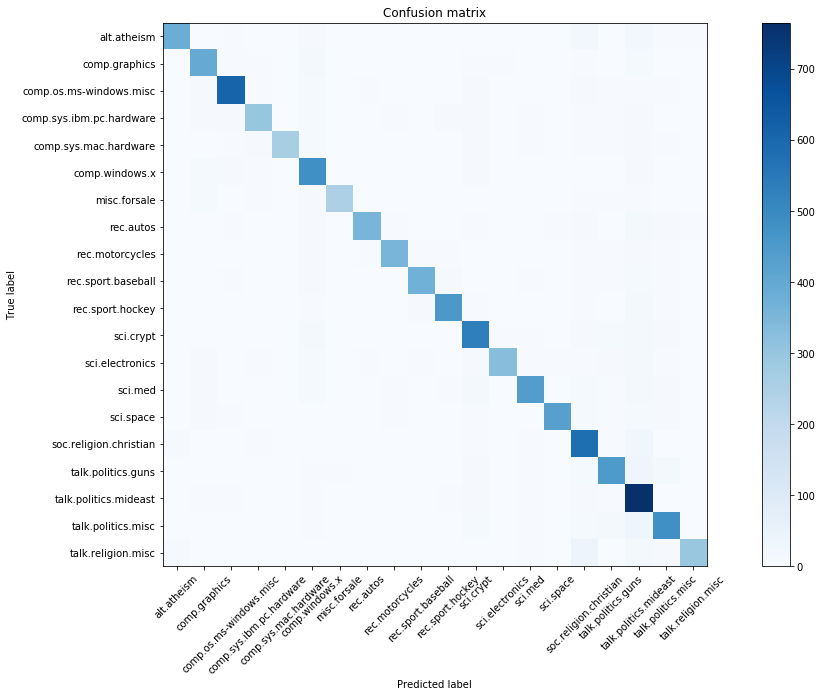

In [0]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

#Making predictions for a Kaggle test set

In [0]:
X_test_final = pd.read_csv("test.csv")

In [41]:
X_test_final.shape

(91122, 3)

In [42]:
X_test_final.head()

,Id,difficulty,ciphertext
0,ID_65f17e60f,1,a1t01OAAata^O81 /e1'O_f1q1at;v1'#ttos1QQv8...
1,ID_ba83b2917,2,^V*$z8d*e4z88SF38e*8|8SFO8Hh}m}[8^7$8A84ej{...
2,ID_ff4e56b9c,3,$*c8?l{{?$8Giw{8{7$8Z9J8Edj?O$*8_n}{87U$8{7...
3,ID_81b64cbc5,2,"nL6! 8lL6M84VkVoh$887h}8h}88 ,8z888888888..."
4,ID_851f738e5,2,}8z8}{Vv$H8h86*4$hVWz8z8\%p8\Sp8lf9V*{7v[8\...


While deciphering the test set, I encountered a problem – ciphers 1 and 2 mappings found by Flal are incomplete! That means they don't cover all characters occurring in encrypted texts. They don't even cover all alphanumeric characters! Apparently, those characters were so rare they didn't even appear in train set, but were present in the much larger test set, which raised multiple KeyErrors when trying to decipher it.

In [0]:
import string

chars = set(string.printable)

In [44]:
chars - set(cipher[1].keys()) #cipher 1 mapping is missing some important characters

{'\n', '\x0b', '\r', '7', 'C', 'M', 'N', 'R', 'j'}

In [45]:
chars - set(cipher[2].keys()) #and cipher 2 mapping, too!

{'\x0b', '\r', 'D', 'U', 'w'}

So I had no choice but to simply ignore every character the mappings fail to decypher.

In [0]:
def decipher(text, cipher):
    result = ''
    for i in range(len(text)):
        try:
            result += cipher[text[i]]
        except KeyError:
            result += ''
    return result

Since this test set is really huge, decrypting it in-place will be slow and unefficient. Instead it's better to make predictions right away, decrypting texts if needed.

In [0]:
def predict(X_test):
    y_pred = []
    for i in range(len(X_test)):
        if X_test['difficulty'][i] == 1 or X_test['difficulty'][i] == 2:
            text = decipher(X_test['ciphertext'][i], cipher[X_test['difficulty'][i]])
            y_pred.append(pipeline_decrypt.predict([text])[0])
        else:
            y_pred.append(pipeline_encrypt.predict([X_test['ciphertext'][i]])[0])
    return y_pred

y_pred_final = predict(X_test_final)

In [0]:
series = [X_test_final['Id'], pd.Series(y_pred_final)]
submission = pd.concat(series, axis=1)
submission.columns = ['Id', 'Predicted']

In [52]:
submission.head()

,Id,Predicted
0,ID_65f17e60f,15
1,ID_ba83b2917,2
2,ID_ff4e56b9c,7
3,ID_81b64cbc5,15
4,ID_851f738e5,17


In [0]:
submission.to_csv("submission.csv", index=False) #saving and downloading locally
files.download("submission.csv")

Macro F1 score on a Kaggle competition test set – 0.49459.